In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sys, importlib, os

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
repo_paths = ['/home/simonealbanesi/repos/IPAM2021_ML/', '/home/simone/repos/IPAM2021_ML/']
for rp in repo_paths:
    if os.path.isdir(rp):
        repo_path = rp
        break
sys.path.insert(0, repo_path+'utils/')

In [4]:
import utils as ut
import classyNN as cnn
import errstats as es
import fancyplots as fp
import errsurf 

2022-07-12 18:48:13.393446: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-12 18:48:13.393473: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
hlayers_sizes   = (100,100)
seed            = 1
verbose_train   = False
epochs          = 100
batch_size      = 128

show_figs       = True
save_figs       = False

compact_bounds = {}
compact_bounds['A'] = [0.5,0.5,0.5]
compact_bounds['B'] = [3,3,3]


## Load data 

In [6]:
data_path = repo_path+'datasets/GSTLAL_EarlyWarning_Dataset/Dataset/m1m2Mc/'
xtrain = cnn.extract_data(data_path+'xtrain.csv')
ytrain = cnn.extract_data(data_path+'ytrain.csv')
xtest  = cnn.extract_data(data_path+'xtest.csv')
ytest  = cnn.extract_data(data_path+'ytest.csv')

nfeatures = len(xtrain[0,:])
names   = ['m1', 'm2', 'Mc'];

--------------------------------------------------  train  -------------------------------------------------


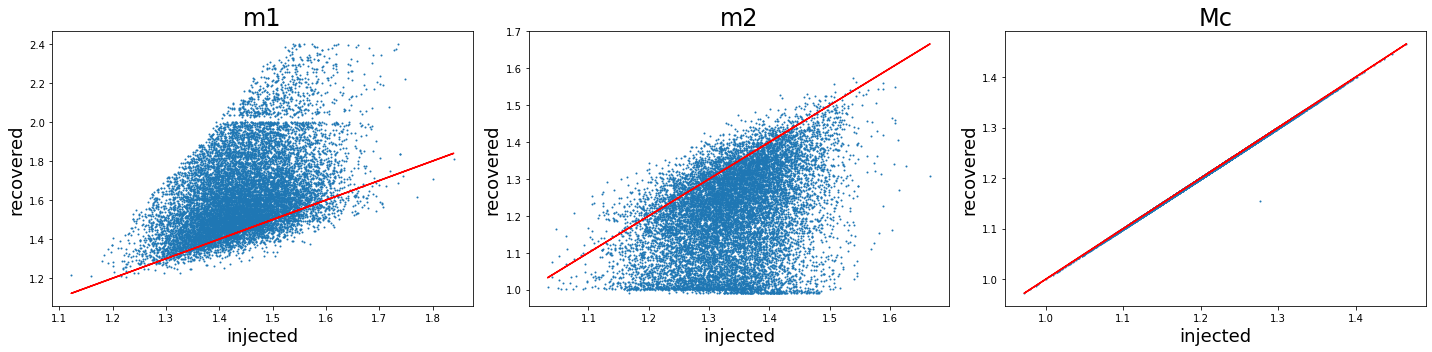

In [7]:
print('-'*50,' train ','-'*49)
plt.figure(figsize=(20,5))
for i in range(nfeatures):
    ax = plt.subplot(1,3,i+1)
    ax.scatter(ytrain[:,i], xtrain[:,i],s=1)
    ax.plot(ytrain[:,i], ytrain[:,i], 'r')
    ax.set_title(names[i], fontsize=24)
    ax.set_xlabel('injected', fontsize=18)
    ax.set_ylabel('recovered', fontsize=18)
plt.tight_layout()
if save_figs:
    plt.savefig('rec_vs_inj.png',dpi=200,bbox_inches='tight')
if show_figs:
    plt.show()
else:
    plt.close()

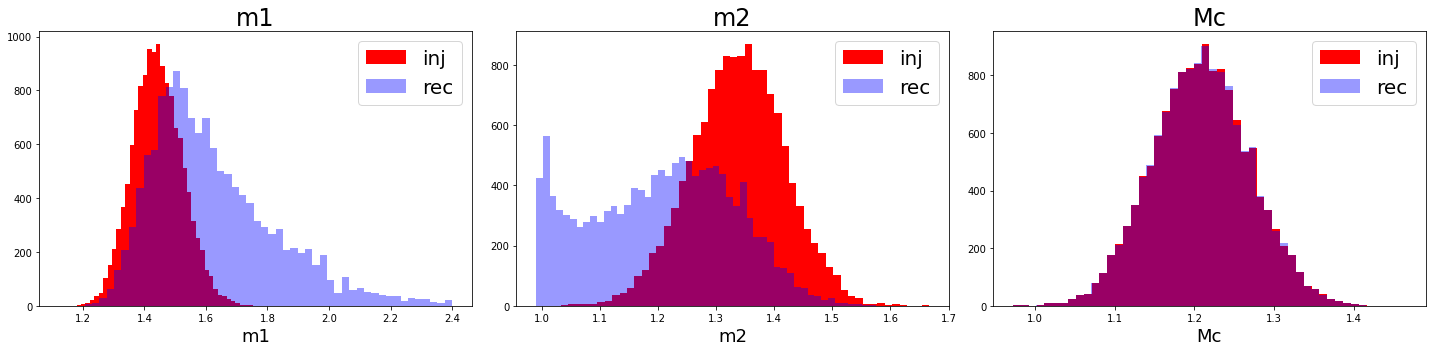

In [8]:
plt.figure(figsize=(20,5))
nbins = 30
for i in range(nfeatures):
    ax = plt.subplot(1,3,i+1)
    ax.hist(ytrain[:,i], bins=50, alpha=1,   color=[1,0,0], label='inj')
    ax.hist(xtrain[:,i], bins=50, alpha=0.4, color=[0,0,1], label='rec')
    ax.set_title(names[i], fontsize=24)
    ax.set_xlabel(names[i], fontsize=18)
    ax.legend(fontsize=20)
plt.tight_layout()
if save_figs:
    plt.savefig('distr.png',dpi=200,bbox_inches='tight')
if show_figs:
    plt.show()
else:
    plt.close()

## Train NN

In [9]:
NN = cnn.RegressionNN(nfeatures=nfeatures, hlayers_sizes=hlayers_sizes,seed=seed)
NN.print_summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 100)               400       
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 3)                 303       
                                                                 
Total params: 10,803
Trainable params: 10,803
Non-trainable params: 0
_________________________________________________________________


2022-07-12 18:48:18.027518: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-12 18:48:18.027581: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-12 18:48:18.027614: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (simone-Lenovo-G50-80): /proc/driver/nvidia/version does not exist
2022-07-12 18:48:18.028019: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
NN.load_train_dataset(xtrain_data=xtrain, ytrain_data=ytrain, 
                      verbose=False, compact_bounds=compact_bounds)

In [11]:
NN.training(epochs=epochs, batch_size=batch_size, verbose=verbose_train)

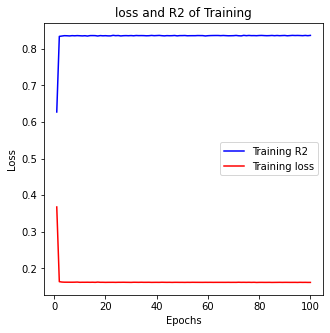

In [12]:
NN.plot_history(show=show_figs, save=save_figs)

## Check prediction

In [13]:
NN.load_test_dataset(xtest_data=xtest, ytest_data=ytest)
NN.print_metrics()

Final R2 mean  : 0.83620
R2[ 0]         : 0.73295
R2[ 1]         : 0.77587
R2[ 2]         : 0.99978


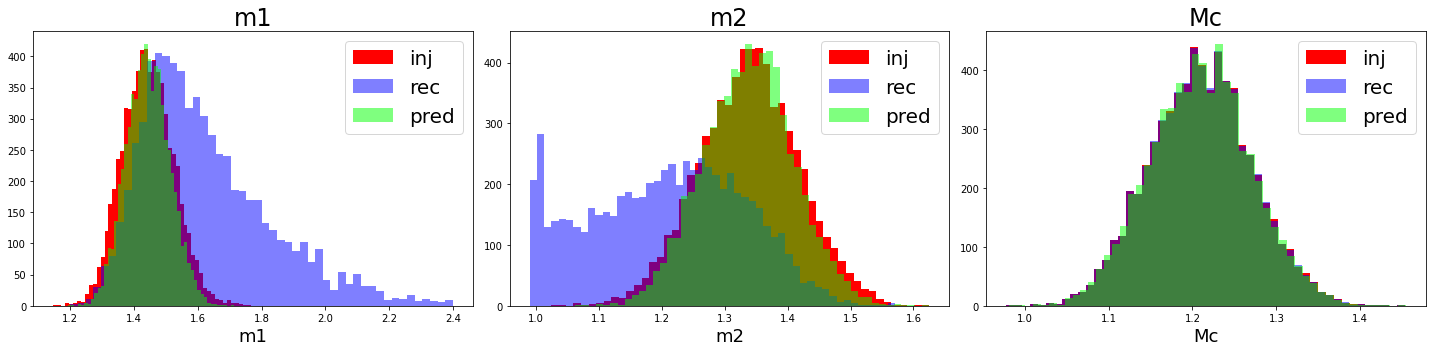

In [14]:
pred = NN.compute_prediction(NN.xtest, transform_output=True) # normalized prediction
plt.figure(figsize=(20,5))
nbins = 30
for i in range(nfeatures):
    ax = plt.subplot(1,3,i+1)
    ax.hist(ytest[:,i], bins=50, alpha=1,   color=[1,0,0], label='inj')
    ax.hist(xtest[:,i], bins=50, alpha=0.5, color=[0,0,1], label='rec')
    ax.hist( pred[:,i], bins=50, alpha=0.5, color=[0,1,0], label='pred')
    ax.set_title(names[i], fontsize=24)
    ax.set_xlabel(names[i], fontsize=18)
    ax.legend(fontsize=20)
plt.tight_layout()
if save_figs:
    plt.savefig('distr_wpred.png',dpi=200,bbox_inches='tight')
if show_figs:
    plt.show()
else:
    plt.close()

------------------------------------------------ m1 --------------------------------------------------
mean rec   rel diff  :  -0.12493 (std= 0.12255, | rel diff |= 0.13107)
mean pred  rel diff  :  -0.00113 (std= 0.02854, | rel diff |= 0.02303)


median rec   rel diff  :  -0.09535
median pred  rel diff  :  -0.00606


recovery   below fmin= -1.00: 0
recovery   above fmax=  1.00: 0
prediction below fmin= -1.00: 0
prediction above fmax=  1.00: 0


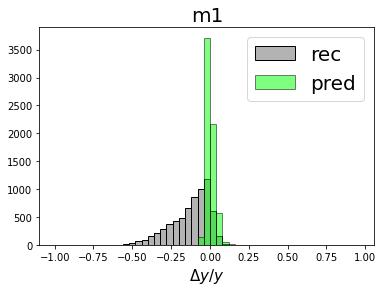

-----------------------------------------------  m2 --------------------------------------------------
mean rec  difference :   0.13106 (std= 0.11887, |difference|= 0.13904)
mean pred difference :   0.00021 (std= 0.03719, |difference|= 0.02995)


median rec  difference :   0.11284
median pred difference :   0.00679


recovery   below fmin= -1.00: 0
recovery   above fmax=  1.00: 0
prediction below fmin= -1.00: 0
prediction above fmax=  1.00: 0


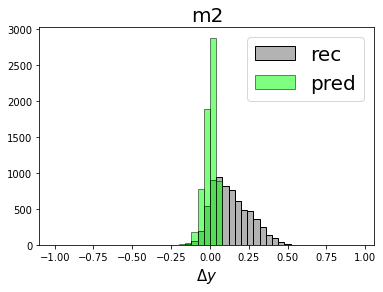

------------------------------------------------ Mc --------------------------------------------------
mean rec  difference :   0.00008 (std= 0.00015, |difference|= 0.00010)
mean pred difference :  -0.00058 (std= 0.00064, |difference|= 0.00071)


median rec  difference :   0.00004
median pred difference :  -0.00053


recovery   below fmin= -0.01: 0
recovery   above fmax=  0.01: 0
prediction below fmin= -0.01: 0
prediction above fmax=  0.01: 0


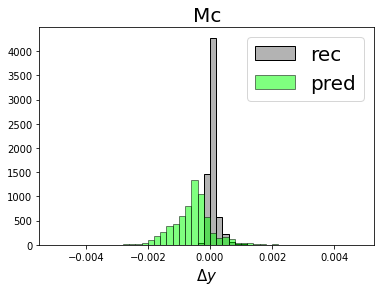

In [15]:
nolatex_names = [ 'm1',   ' m2',    'Mc' ]
fmin_vec      = [   -1,     -1 ,   -0.005]
fmax_vec      = [    1,      1 ,    0.005]
abs_diff_vec  = [False,     True,    True]
logscale_vec  = [False,    False,   False]

for i in range(nfeatures):
    print('-'*(50-len(nolatex_names[i])), nolatex_names[i], '-'*50)
    NN.plot_err_histogram(feature_idx=i, fmin=fmin_vec[i], fmax=fmax_vec[i], verbose=True, 
                          abs_diff=abs_diff_vec[i], name=names[i], show=show_figs, save=save_figs, 
                          logscale=logscale_vec[i], nbins=50)

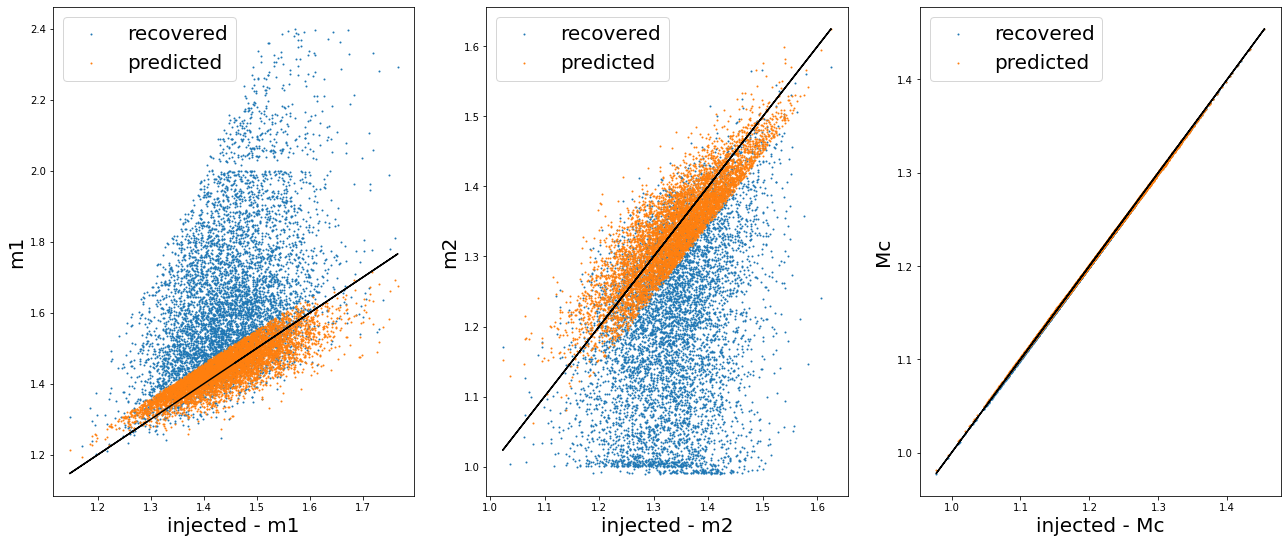

In [16]:
prediction = NN.compute_prediction(NN.xtest) # normalized prediction
fp.checkRegressionPlot(NN.xtest, NN.ytest, prediction, names, 
                              scaler_y=NN.scaler_y, scaler_x=NN.scaler_x, show=show_figs, save=save_figs)

## Error stats

In [17]:
"""
importlib.reload(es)

predicted = NN.compute_prediction(NN.xtrain, transform_output=True)
injected  = NN.ytrain_notnorm
recovered = NN.xtrain_notnorm

X = [recovered, predicted]
dsets = ['recovered', 'predicted']

for i in range(nfeatures):
    print('#'*100, '\nfeatures n.', i, ': ', names[i], '\n', '#'*100, sep='')
    for x, dset in zip(X, dsets):
        print('-'*100, '\ndset: ', dset, '\n', '-'*100, sep='', end='\n\n')
        ErrorStats = es.ErrorStats(verbose=False)
        ErrorStats.fit(x[:,i],injected[:,i], n=565, project=True, sigma=5, shift_extrema=True, npoly=[3,2,1]) 
        ErrorStats.plot_bins()
        #ErrorStats.plot_xstep()
        ErrorStats.plot_moments(plot_poly_fit=True)
        ErrorStats.plot_stats(plot_xbins=False, show_info=False, plot_exact_distr=True, 
                              plot_distr=True, show_gauss=True)
""";

In [18]:
"""
# test save/load methods

importlib.reload(es)

ErrorStats = es.ErrorStats(verbose=True)
ErrorStats.fit(predicted[:,0],injected[:,0], n=565, project=True, sigma=5, shift_extrema=True, npoly=[3,2,1])
ErrorStats.plot_moments(plot_poly_fit=True)
ErrorStats.save('err_model.dill', verbose=True)

ErrorStats2 = es.ErrorStats(verbose=False)
ErrorStats2.load('err_model.dill', verbose=True)
ErrorStats.plot_moments(plot_poly_fit=True)
""";

## Example of complete pipeline

In [19]:
importlib.reload(es)
# 1) train the ML model
# ...

# 2) fit error-model for each feature
train_rec  = NN.xtrain_notnorm
train_inj  = NN.ytrain_notnorm
train_pred = NN.compute_prediction(train_rec, transform_input=True, transform_output=True)
ES_rec  = []
ES_pred = []
for i in range(nfeatures):
    esrec  = es.ErrorStats()
    esrec.fit(train_rec[:,i],   train_inj[:,i], n=565, project=True, sigma=5, shift_extrema=True, npoly=[3,2,1])
    ES_rec.append(esrec)
    espred = es.ErrorStats()
    espred.fit(train_pred[:,i], train_inj[:,i], n=565, project=True, sigma=5, shift_extrema=True, npoly=[3,2,1])
    ES_pred.append(espred)

# obtain prediction of the test dataset
test_rec  = NN.xtest_notnorm
test_inj  = NN.ytest_notnorm
test_pred = NN.compute_prediction(test_rec, transform_input=True, transform_output=True)

# Is the prediction of the NN our final prediction? Seems not

In [20]:
idx       = 123
conf      = 0.95
show_plot = False

rec  =  test_rec[idx,:]
inj  =  test_inj[idx,:]
pred = test_pred[idx,:]

names = ['m1', 'm2', 'Mc']
for i in range(nfeatures):
    print('-'*30, '\n',' '*14, names[i], '\n', '-'*30, sep='')
    print('inj  : {:.5f}'.format(inj[i]) )
    x1, x2, ymean = ES_rec[i].confidence_interval(rec[i], conf, plot=show_plot);
    print('rec  : {:.5f} --> ymean: {:.5f}, ({:.5f}, {:.5f})'.format(rec[i], ymean, ymean+x1, ymean+x2))
    x1, x2, ymean = ES_pred[i].confidence_interval(pred[i], conf, plot=show_plot);
    print('pred : {:.5f} --> ymean: {:.5f}, ({:.5f}, {:.5f})'.format(pred[i], ymean, ymean+x1, ymean+x2))
    print('\n')

------------------------------
              m1
------------------------------
inj  : 1.41280
rec  : 1.53990 --> ymean: 1.44205, (1.31166, 1.58238)
pred : 1.44937 --> ymean: 1.44930, (1.39583, 1.54946)


------------------------------
              m2
------------------------------
inj  : 1.38476
rec  : 1.27276 --> ymean: 1.34136, (1.21386, 1.47581)
pred : 1.35166 --> ymean: 1.35167, (1.26491, 1.40496)


------------------------------
              Mc
------------------------------
inj  : 1.21763
rec  : 1.21764 --> ymean: 1.21773, (1.21756, 1.21805)
pred : 1.21827 --> ymean: 1.21780, (1.21713, 1.21847)




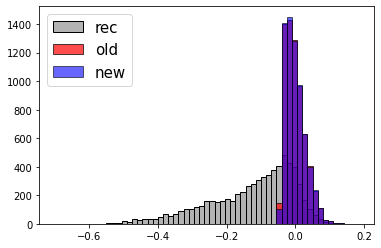

rec   |mean|: 0.13106668    mean: -0.12493221    std: 0.12255269
old   |mean|: 0.02302981    mean: -0.00112924    std: 0.02854084
new   |mean|: 0.02295008    mean: -0.00088561    std: 0.02849355


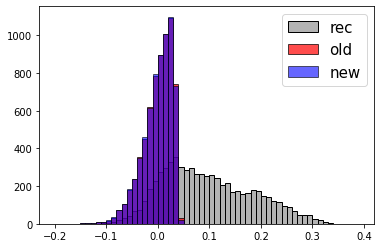

rec   |mean|: 0.10296014    mean:  0.09667856    std: 0.08656978
old   |mean|: 0.02267197    mean: -0.00059902    std: 0.02870558
new   |mean|: 0.02264198    mean: -0.00077857    std: 0.02870249


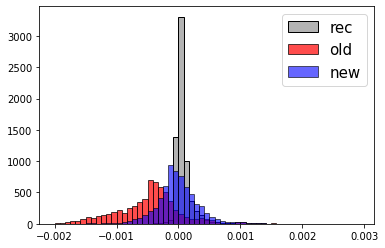

rec   |mean|: 0.00008266    mean:  0.00006834    std: 0.00012400
old   |mean|: 0.00060006    mean: -0.00049909    std: 0.00055943
new   |mean|: 0.00024773    mean: -0.00001964    std: 0.00033814


In [21]:
N = len(test_inj[:,0])
new_pred = np.empty((N,nfeatures))
for i in range(N):
    for j in range(nfeatures):
        new_pred[i,j] = ES_pred[j].return_mean_from_poly_fit(test_pred[i,j])

errors_rec = (test_inj- test_rec)/test_inj
errors_new = (test_inj- new_pred)/test_inj
errors_old = (test_inj-test_pred)/test_inj

nbins = 60
fmin = np.array([-0.7, -0.2, -0.002])
fmax = np.array([ 0.2,  0.4,  0.003])
fstep = (fmax-fmin)/nbins

for i in range(nfeatures):
    plt.figure
    plt.hist(errors_rec[:,i], bins=np.arange(fmin[i],fmax[i],fstep[i]), alpha=1.0,  
             color=[0.7,0.7,0.7], label='rec', histtype='bar', ec='black')
    plt.hist(errors_old[:,i], bins=np.arange(fmin[i],fmax[i],fstep[i]), alpha=0.7,  
             color=[1,0,0], label='old', histtype='bar', ec='black')
    plt.hist(errors_new[:,i], bins=np.arange(fmin[i],fmax[i],fstep[i]), alpha=0.6,  
             color=[0,0,1], label='new', histtype='bar', ec='black')
    plt.legend(fontsize=15)
    plt.show()
    
    r = errors_rec[:,i]
    o = errors_old[:,i]
    n = errors_new[:,i]
    print('rec   |mean|:{:11.8f}    mean:{:12.8f}    std:{:11.8f}'.format(np.mean(np.abs(r)),np.mean(r),np.std(r)))
    print('old   |mean|:{:11.8f}    mean:{:12.8f}    std:{:11.8f}'.format(np.mean(np.abs(o)),np.mean(o),np.std(o))) 
    print('new   |mean|:{:11.8f}    mean:{:12.8f}    std:{:11.8f}'.format(np.mean(np.abs(n)),np.mean(n),np.std(n)))

## Surface errors



####################################################################################################
                                                m1
####################################################################################################


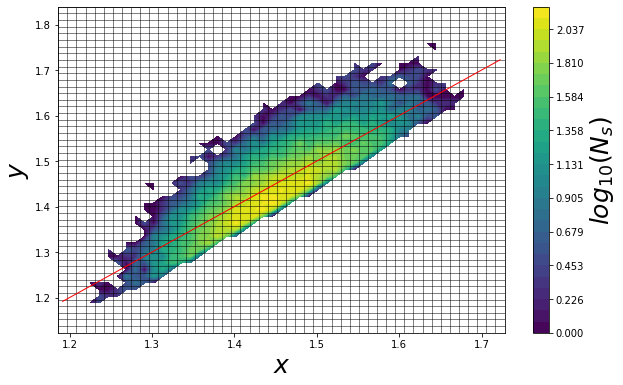

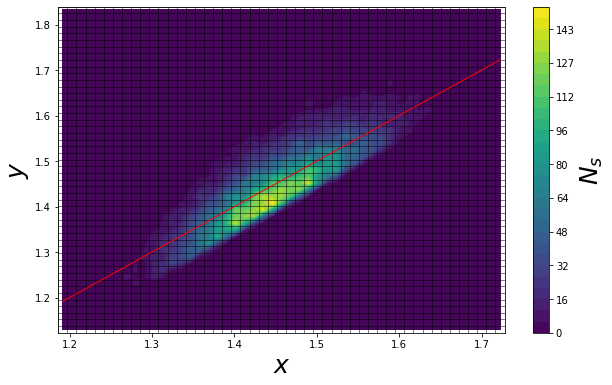

----------------------------------------------------------------------------------------------------
                                          m1: 1.35
----------------------------------------------------------------------------------------------------


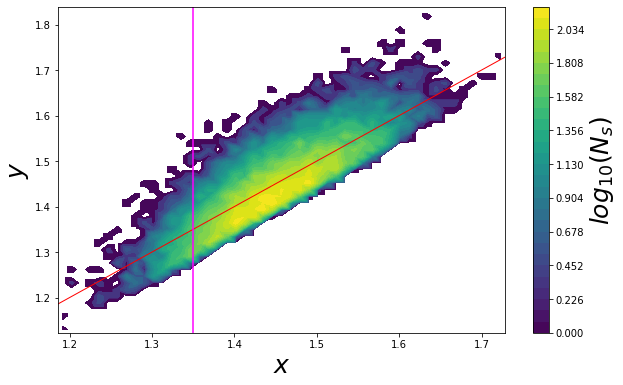

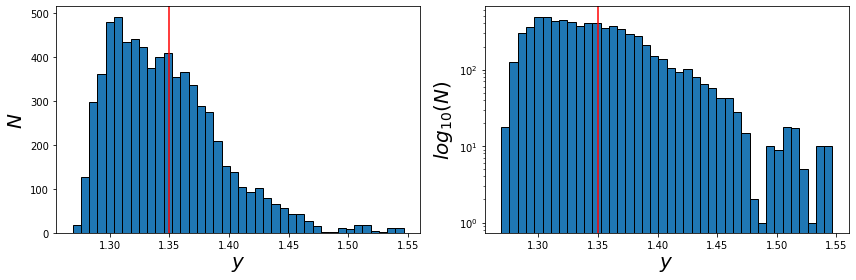

----------------------------------------------------------------------------------------------------
                                          m1: 1.45
----------------------------------------------------------------------------------------------------


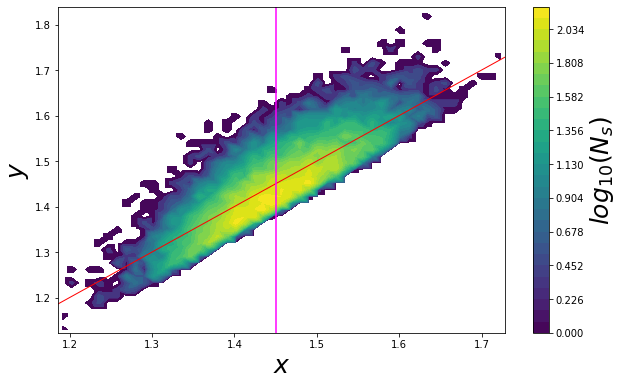

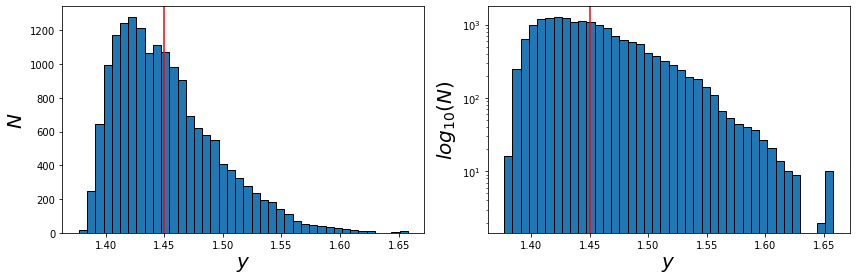



####################################################################################################
                                                m2
####################################################################################################


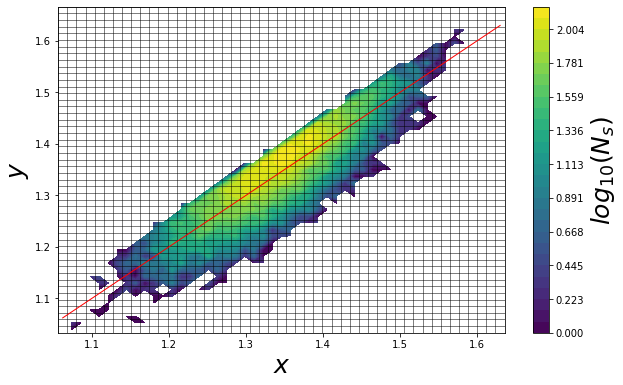

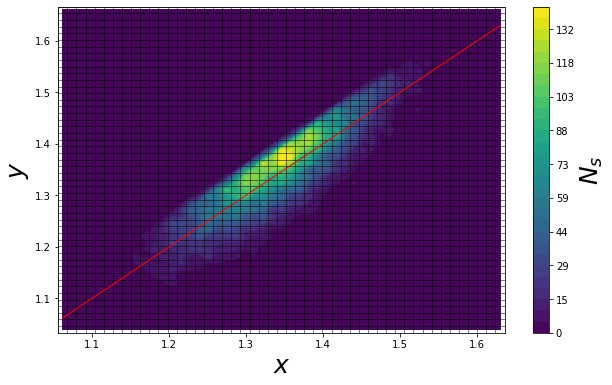

----------------------------------------------------------------------------------------------------
                                          m2: 1.25
----------------------------------------------------------------------------------------------------


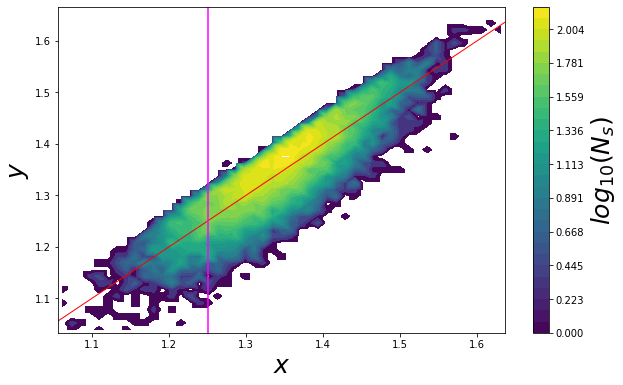

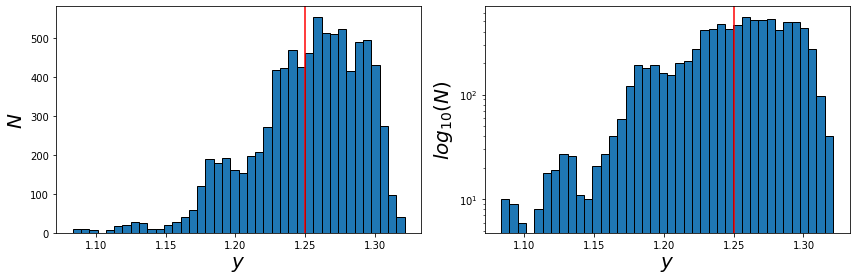

----------------------------------------------------------------------------------------------------
                                          m2: 1.35
----------------------------------------------------------------------------------------------------


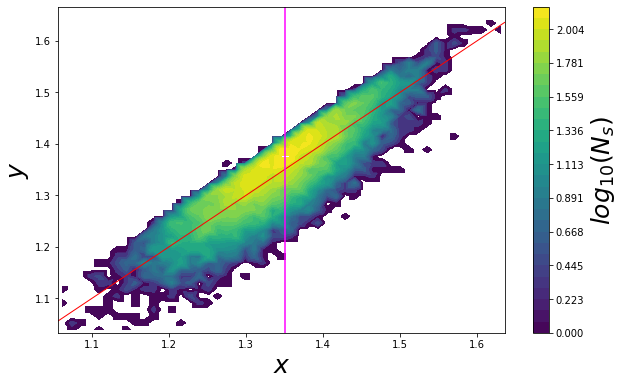

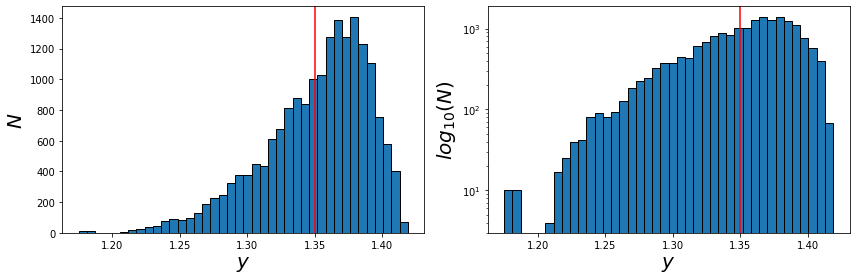



####################################################################################################
                                                Mc
####################################################################################################


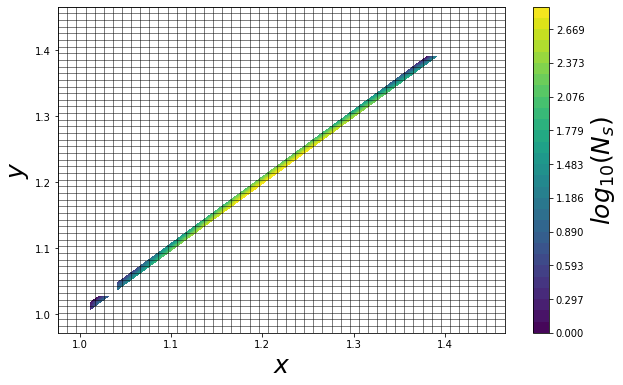

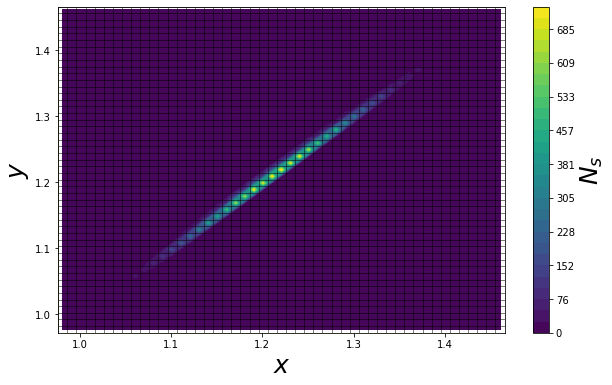

----------------------------------------------------------------------------------------------------
                                          Mc: 1.1
----------------------------------------------------------------------------------------------------


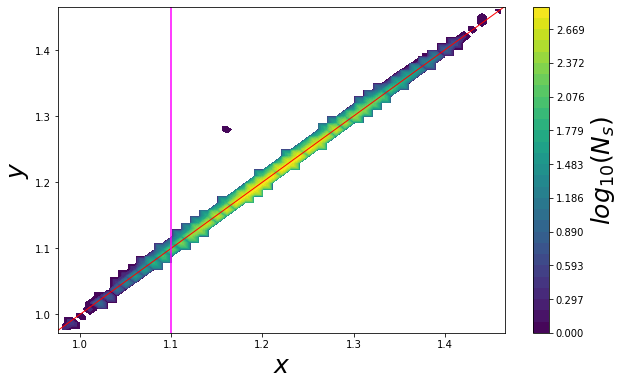

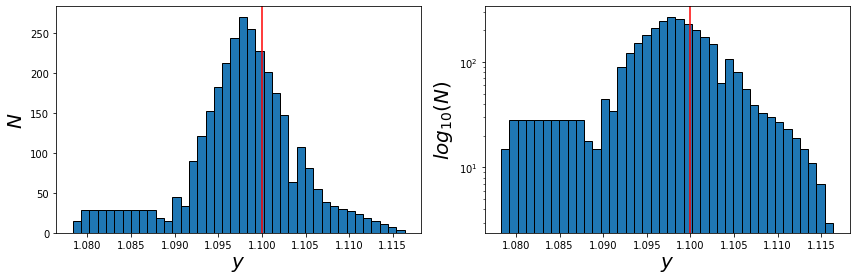

----------------------------------------------------------------------------------------------------
                                          Mc: 1.165
----------------------------------------------------------------------------------------------------


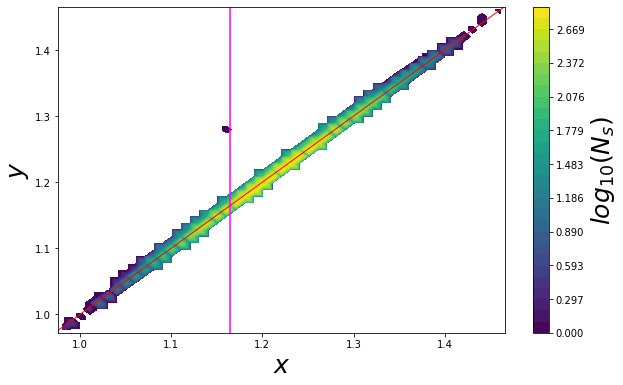

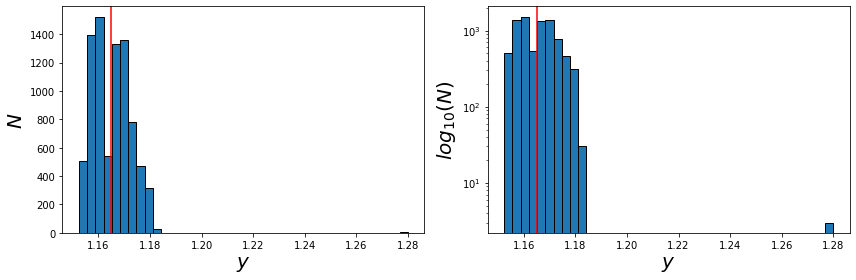

----------------------------------------------------------------------------------------------------
                                          Mc: 1.3
----------------------------------------------------------------------------------------------------


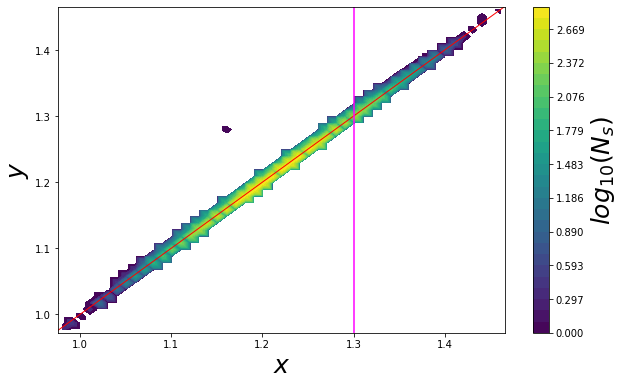

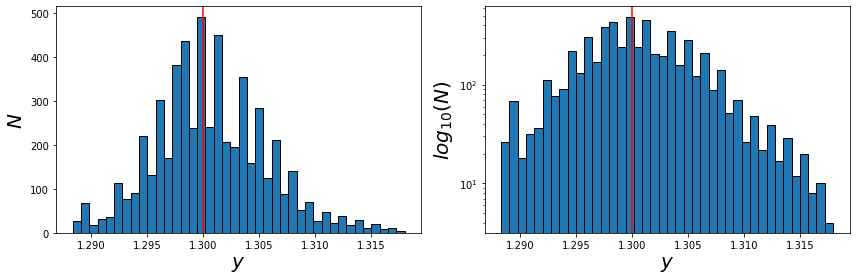

In [22]:
importlib.reload(errsurf)

feature_names = ['m1', 'm2', 'Mc']

x0_list         = {}
x0_list['m1']   = [1.35, 1.45]
x0_list['m2']   = [1.25, 1.35]
x0_list['Mc']   = [1.1, 1.165, 1.3]
exp_step_vec    = [False, False, False]
log_scale_vec   = [False, False, False]
bisectrix_vec   = [True,  True,  False]
esurf_list = []
for i in range(len(feature_names)):
    f = feature_names[i]
    print('\n', '#'*100, ' '*48+f, '#'*100, sep='\n')
    esurf = errsurf.ErrorSurface(train_pred[:,i], train_inj[:,i], Nx=50, Ny=50, 
                                    exp_step=exp_step_vec[i], dx_expstep=1.05, dy_expstep=1.05,
                                    method='linear', Nx_grid=1000, Ny_grid=1000)
    esurf.plot_surf(log_scale=log_scale_vec[i], log_bar=True, bisectrix=bisectrix_vec[i])
    esurf.plot_surf(log_scale=log_scale_vec[i], log_bar=False, bisectrix=bisectrix_vec[i])
    nbins   = 40
    for x0 in x0_list[f]:
        print('-'*100, ' '*42+f+': '+str(x0), '-'*100, sep='\n')
        esurf.plot_interp(x0_line=x0, log_scale=False, log_bar=True)
        esurf.plot_hist(x0, nbins=nbins)
    esurf_list.append(esurf)

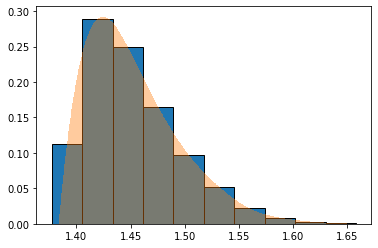

----------------------------------------------------------------------------------------------------
cfi requested                  : 0.900000
number of bins                 : 999
left-idf, right-idx            : 73, 564
left-tail prob, left-tail prob : 0.05093, 0.05029
final cfi (diff from initial)  : 0.89878 (-0.135034 %)
sum of final cfi and compl-cfi : 1.0000000000
----------------------------------------------------------------------------------------------------


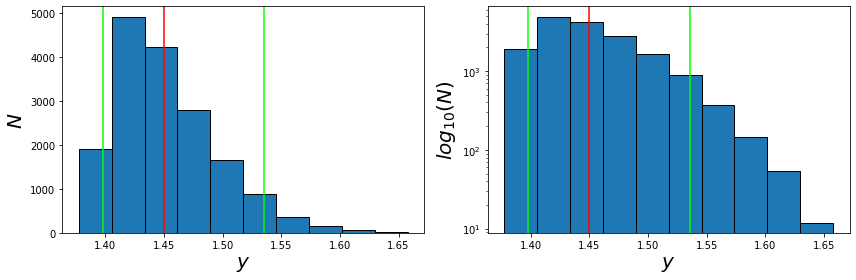

[1.397770,1.535686] -> 0.898785


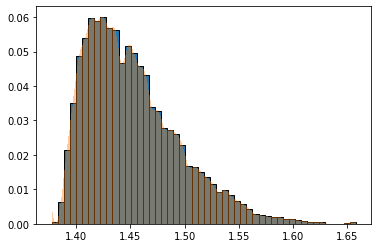

----------------------------------------------------------------------------------------------------
cfi requested                  : 0.900000
number of bins                 : 999
left-idf, right-idx            : 73, 563
left-tail prob, left-tail prob : 0.05089, 0.05020
final cfi (diff from initial)  : 0.89891 (-0.121252 %)
sum of final cfi and compl-cfi : 1.0000000000
----------------------------------------------------------------------------------------------------


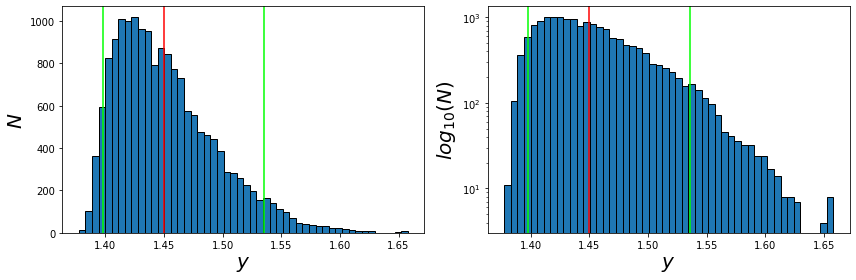

[1.397770,1.535405] -> 0.898909


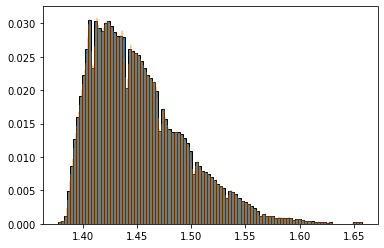

----------------------------------------------------------------------------------------------------
cfi requested                  : 0.900000
number of bins                 : 999
left-idf, right-idx            : 74, 563
left-tail prob, left-tail prob : 0.05176, 0.05033
final cfi (diff from initial)  : 0.89791 (-0.232294 %)
sum of final cfi and compl-cfi : 1.0000000000
----------------------------------------------------------------------------------------------------


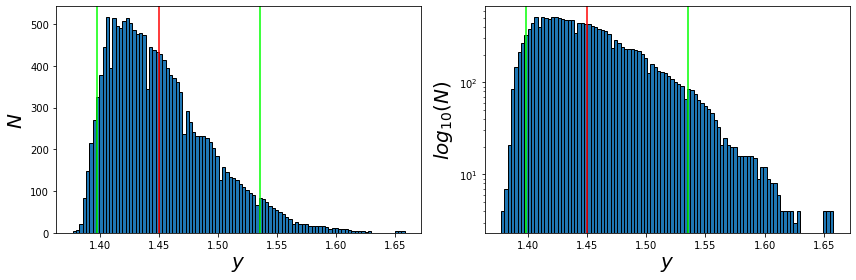

[1.398051,1.535405] -> 0.897909


In [23]:
importlib.reload(errsurf)

idx = 0
nbins_vec = [10, 50, 100]
x0 = 1.45
for nbins in nbins_vec:
    xl, xr, cfi_final = esurf_list[idx].confidence_interval(x0, cfi=0.90, verbose=True, nbins=nbins, 
                                                  spline=True, spline_sample=1000, spline_plot=True)
    esurf_list[idx].plot_hist(x0, nbins=nbins, axvlines=[xl, xr])
    print('[{:f},{:f}] -> {:f}'.format(xl, xr, cfi_final))

In [24]:
"""
N = len(test_inj[:,0])
new_pred = np.empty((N,nfeatures))
for j in range(nfeatures):
    print(j)
    for i in range(N):
        if not i%1000:
            print(j,':',i)
        y = esurf_list[j].distribution(test_pred[i,j])
        if y.size!=0:
            new_pred[i,j] = np.mean(y)
        else:
            new_pred[i,j] = test_pred[i,j]

errors_rec = (test_inj- test_rec)/test_inj
errors_new = (test_inj- new_pred)/test_inj
errors_old = (test_inj-test_pred)/test_inj

nbins = 60
fmin = np.array([-0.7, -0.2, -0.002])
fmax = np.array([ 0.2,  0.4,  0.003])
fstep = (fmax-fmin)/nbins

for i in range(nfeatures):
    plt.figure
    plt.hist(errors_rec[:,i], bins=np.arange(fmin[i],fmax[i],fstep[i]), alpha=1.0,  
             color=[0.7,0.7,0.7], label='rec', histtype='bar', ec='black')
    plt.hist(errors_old[:,i], bins=np.arange(fmin[i],fmax[i],fstep[i]), alpha=0.7,  
             color=[1,0,0], label='old', histtype='bar', ec='black')
    plt.hist(errors_new[:,i], bins=np.arange(fmin[i],fmax[i],fstep[i]), alpha=0.6,  
             color=[0,0,1], label='new', histtype='bar', ec='black')
    plt.legend(fontsize=15)
    plt.show()
    
    r = errors_rec[:,i]
    o = errors_old[:,i]
    n = errors_new[:,i]
    print('rec   |mean|:{:11.8f}    mean:{:12.8f}    std:{:11.8f}'.format(np.mean(np.abs(r)),np.mean(r),np.std(r)))
    print('old   |mean|:{:11.8f}    mean:{:12.8f}    std:{:11.8f}'.format(np.mean(np.abs(o)),np.mean(o),np.std(o))) 
    print('new   |mean|:{:11.8f}    mean:{:12.8f}    std:{:11.8f}'.format(np.mean(np.abs(n)),np.mean(n),np.std(n)))
""";